# Supplementary material: data for parmest tutorial

Created by [Kanishka Ghosh](https://github.com/kanishka-ghosh), [Jialu Wang](https://github.com/jialuw96), and [Prof. Alex Dowling](https://github.com/adowling2/) at the University of Notre Dame.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *

# Define the directory to save/read the data files
data_dir = 'https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/data/parmest_tutorial/'

The **purpose of this notebook** is to generate data files used for the parmest tutorial.

## Reaction Kinetics Example

The following code calculates the concentrations $C_A$, $C_B$, and $C_C$ as a function of time for experimental conditions $T$ and $C_{A0}$ given model parameters $A_1$, $A_2$, $E_1$, and $E_2$. See the parmest tutorial notebook for a full description of the mathematical model.

In [2]:
def kinetics(A, E, T):
    ''' Computes kinetics from Arrhenius equation
    
    Arguments:
        A: pre-exponential factor, [1 / hr]
        E: activation energy, [kJ / mol]
        T: temperature, [K]
        
    Returns:
        k: reaction rate coefficient, [1 / hr]
    
    '''
    R = 8.31446261815324 # J / K / mole
    
    return A * np.exp(-E*1000/(R*T))

def concentrations(t,k,CA0):
    '''
    Returns concentrations at time t
    
    Arguments:
        t: time, [hr]
        k: reaction rate coefficient, [1 / hr]
        CA0: initial concentration of A, [mol / L]
    
    Returns:
        CA, CB, CC: concentrations of A, B, and C at time t, [mol / L]
    '''
    CA = CA0 * np.exp(-k[0]*t);
    CB = k[0]*CA0/(k[1]-k[0]) * (np.exp(-k[0]*t) - np.exp(-k[1]*t));
    CC = CA0 - CA - CB;
    
    return CA, CB, CC

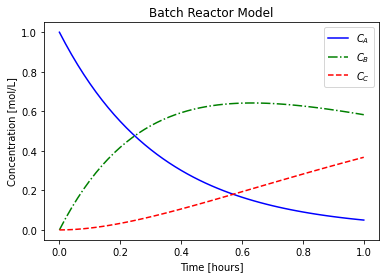

In [3]:
CA0 = 1 # Moles/L
k = [3, 0.7] # 1/hr

t = np.linspace(0,1,51)
CA, CB, CC = concentrations(t,k,CA0)
plt.plot(t, CA, label="$C_{A}$",linestyle="-",color="blue")
plt.plot(t, CB, label="$C_{B}$",linestyle="-.",color="green")
plt.plot(t, CC, label="$C_{C}$",linestyle="--",color="red")
plt.xlabel("Time [hours]")
plt.ylabel("Concentration [mol/L]")
plt.title("Batch Reactor Model")
plt.legend()
plt.show()

### Simulating experimental data

We start by *simulating* experiments in the batch reactor. Here is the experimental procedure:
1. Specify the reaction temperature
2. Load the reactor with species $A$ concentration of $C_{A0}$ mol/L at time $t=0$.
3. Measure the concentrations $C_A$, $C_B$, and $C_C$ at times 0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, and 1.0 hours. These experiments are subject to measurement uncertainty.

Below is Python code to generate data for these simulated experiments.

In [4]:
## General setup

# declare "true" model parameters
A = np.array([200, 400]) # 1/hr
E = np.array([10, 15]) # KJ/mol

# declare time for parameter estimation
t_est = np.array([0.0, 0.125, 0.25, 0.375,0.5,0.625, 0.75, 0.875, 1.0])
n = len(t_est)

# declare measurement uncertainty
stdev_m_error = 0.1

# define function to plot
def plot_exp(k, CA0, data, text):
    ''' 
    Plot concentration profiles
    Arguments:
        k: kinetic parameters
        CA0: initial concentration
        data: Pandas data frame
        text: plot title
    
    '''
    # evaluate models
    t = np.linspace(0,1,51)
    CA, CB, CC = concentrations(t,k,CA0)
    
    # plot model-generated and 'experimental' data
    # symbols for 'experimental' data
    # solid and dashed lines for model-generated data
    plt.plot(t, CA,label="$C_{A}$",linestyle="-",color="blue")
    plt.plot(data.time, data.CA, marker='o',linestyle="",color="blue",label=str())
    plt.plot(t, CB, label="$C_{B}$",linestyle="-.",color="green")
    plt.plot(data.time, data.CB, marker='s',linestyle="",color="green",label=str())
    plt.plot(t, CC, label="$C_{C}$",linestyle="--",color="red")
    plt.plot(data.time, data.CC, marker='^',linestyle="",color="red",label=str())
    plt.xlabel("Time [hours]")
    plt.ylabel("Concentration [mol/L]")
    plt.title(text)
    plt.legend()
    plt.show()

# define function to accept set of T and C_A0 values as input and generate true parameters and data with noise
def gen_data(T_vals,CA0_vals,t_est,std_error,n):
    '''
    function to accept set of T and C_A0 values as input and generate and store data with noise to csv files
    Arguments:
        T_vals: list of temperature, K
        CA0_vals: list of inlet concentrations of A, mol/L
        t_est: time steps for experiment, hrs
        std_error: uncertainty added to data
        n: number of data points = length of t_est
    Return:
        filename_list: list of filenames
    '''
    filename_list = []
    # experiment number counter
    counter = 0
    for T in T_vals:
        for CA0 in CA0_vals:
            counter += 1
            # define "true" kinetic parameters at this temperature
            k = kinetics(A, E, T)

            # evaluate model to generate data
            CA_exp, CB_exp, CC_exp = concentrations(t_est,k,CA0)

            # add measurement error
            # Note: adding random errors to concentration can result in negative concentrations
            # To ensure the data seems realistic, we need to ignore negative concentration data points
            
            CA_exp += np.random.normal(0, std_error, n)
            CB_exp += np.random.normal(0, std_error, n)
            CC_exp += np.random.normal(0, std_error, n)
            
            for i,CA_exp_i in enumerate(CA_exp):
                if CA_exp[i] < 0.0:
                    CA_exp[i] = 0.0
                if CB_exp[i] < 0.0:
                    CB_exp[i] = 0.0
                if CC_exp[i] < 0.0:
                    CC_exp[i] = 0.0

            # store dictionary of 'experimental' data in Pandas dataframe
            data = pd.DataFrame({"time":t_est,"T":T,"CA0":CA0,"CA":CA_exp,"CB":CB_exp,"CC":CC_exp})
            # generate filename to store data in
            file_name = data_dir + '20210609_data_exp{}.csv'.format(counter)
            # store data in csv file segregated by 'experiment' number
            data.to_csv(file_name)
            # adding file name to list of file names to be used later to read-in data from the csv files
            filename_list.append(file_name)
            # plot model-generated and 'experimental' data
            # symbols for 'experimental' data
            # solid and dashed lines for model-generated data
            plot_exp(k, CA0, data, "Experiment {}: T = {} K and $C_{}$ = {} mol/L".format(counter,T,'A0',CA0))
    return filename_list

### Simulate data for multiple experiments

Here, we define lists of temperatures and initial concentrations of A to be used to simulate multiple experimental datasets

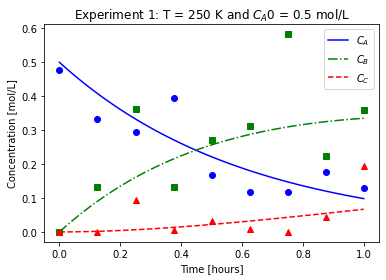

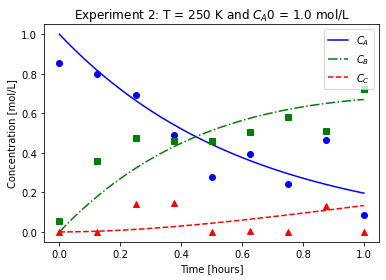

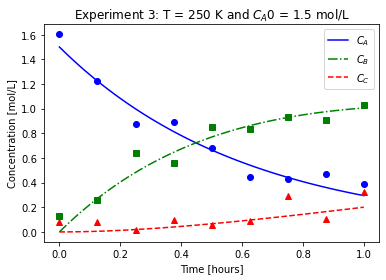

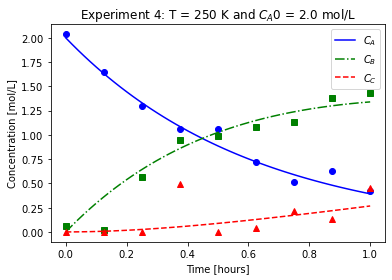

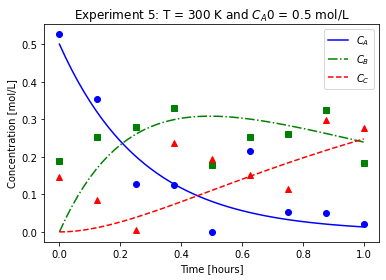

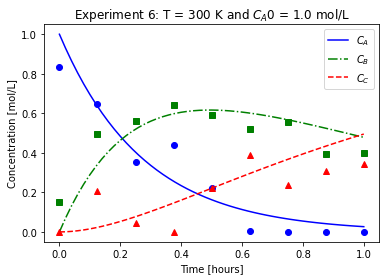

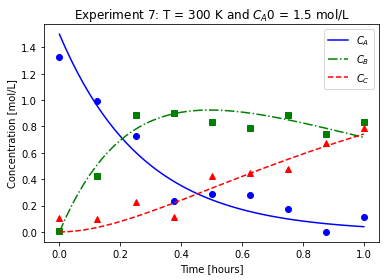

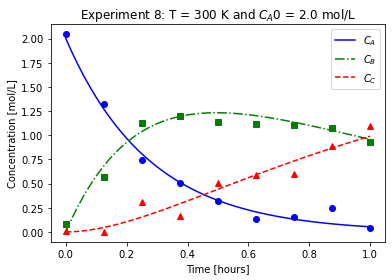

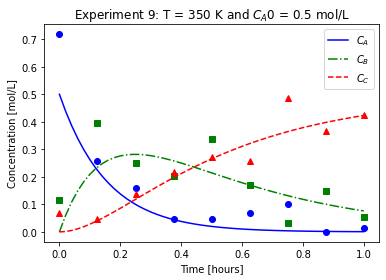

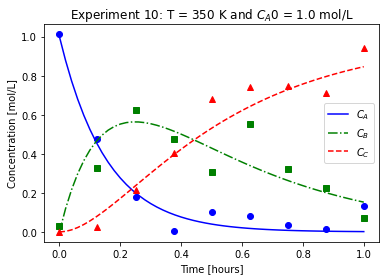

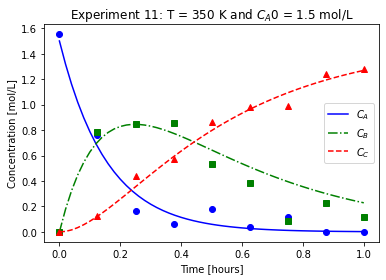

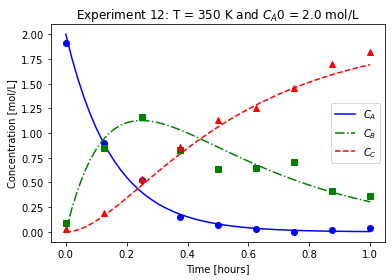

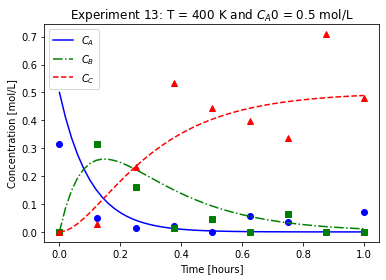

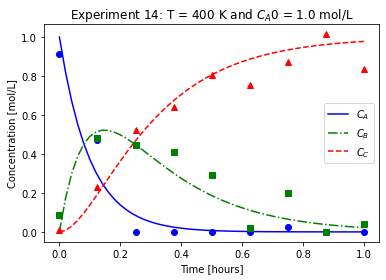

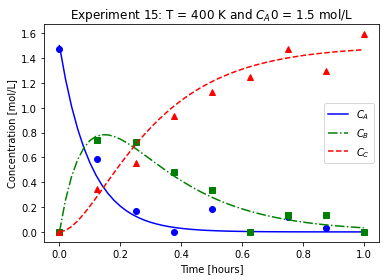

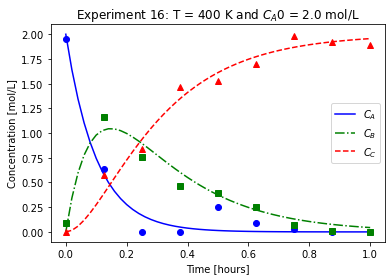

In [5]:
# list of temperatures
T_vals = [250,300,350,400] # K

# list of initial concentrations of A
CA0_vals = [0.5,1.0,1.5,2.0] # mol/L

# generating 'experimental' data and storing list of filenames to be used to load data later
file_list = gen_data(T_vals,CA0_vals,t_est,stdev_m_error,n)

# creating a log file to store file names
log_file_name = data_dir + 'log_file.csv'
# create a pandas dataframe to store file names
file_list_df = pd.DataFrame.from_dict({'File name':file_list})
# save dataframe as a separate csv file
file_list_df.to_csv(log_file_name,index=False)

We will imagine these data came from laboratory experiments.